In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

import sys
sys.path.append('../py_files/')
from feature_creator import get_feature, add_feature

In [56]:
data = pd.read_csv('../data/train_file.csv')
data = data.drop(columns=['timestamp_milllisecs'])

In [78]:
train_size=0.8
split_index = int(train_size*len(data))
X = data.drop(columns=['label'])
y = data['label']

def get_diff(data, periods=1):
    data_diff = data.diff(periods=periods).fillna(0)
    data_diff.columns = [f'{i}_diff_{periods}' for i in data.columns]
    return data_diff

def add_features_data(data, data_feature, ws=5):
    for new_feature in ['iemg', 'ssi']:
        new_feature_name = f'{data_feature}_{new_feature}_{ws}'
        new_feature_array = get_feature(
            data[data_feature], ws, new_feature
        )
        data[new_feature_name] = new_feature_array
    return data

def split_data(X, y):
    x_train, y_train = X[:split_index], y[:split_index]
    x_test, y_test = X[split_index:], y[split_index:]
    return x_train, y_train, x_test, y_test 

def feature_engineering(data):
    data_new = pd.concat([data, get_diff(data), get_diff(data, periods=2)], axis=1)
    for column_name in data_new.columns:
        data_new = add_features_data(data_new, column_name)
#     data_new = data_new.drop(columns=['timestamp_milllisecs'])
    return data_new

def dim_reduction(x_train,x_test):
    clf = PCA(n_components=75)
    clf.fit(x_train)
    x_train = clf.transform(x_train)
    x_test = clf.transform(x_test)
    print('columns left:', x_train.shape[1])
    return x_train, x_test


x_train, y_train, x_test, y_test = split_data(X,y)
x_train_new = feature_engineering(x_train)
x_test_new = feature_engineering(x_test)

# X.shape
counts = np.unique(y_train, return_counts=True)
class_weights = [int(max(counts[1])/i) for i in counts[1]]
weight_dict = dict(zip(counts[0], class_weights))
sample_weight = [weight_dict[i] for i in y_train]

x_train_new, x_test_new = dim_reduction(x_train_new, x_test_new)
    
    

columns left: 75


C:\Users\Dell\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4351
           1       1.00      1.00      1.00       294
           2       1.00      1.00      1.00       294
           3       1.00      1.00      1.00       294
           4       1.00      1.00      1.00       286
           5       1.00      1.00      1.00       280

    accuracy                           1.00      5799
   macro avg       1.00      1.00      1.00      5799
weighted avg       1.00      1.00      1.00      5799

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1092
           1       0.74      0.80    

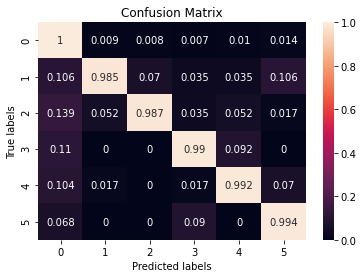

In [79]:
model = XGBClassifier()
model.fit(x_train_new, y_train, sample_weight=sample_weight)
print(classification_report(y_train, model.predict(x_train_new)))
print(classification_report(y_test, model.predict(x_test_new)))
preds = model.predict(x_test_new)

cm = confusion_matrix(preds, y_test)
cm = sklearn.preprocessing.normalize(cm)
cm = np.round(cm, decimals=3)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [71]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
keys

['ch11_diff_2_ssi_5',
 'ch2_diff_2_ssi_5',
 'ch4_iemg_5',
 'ch6',
 'ch3',
 'ch12',
 'ch1_diff_2_ssi_5',
 'ch7_diff_2_ssi_5',
 'ch9_iemg_5',
 'ch4_diff_1_iemg_5',
 'ch14_iemg_5',
 'ch4',
 'ch8',
 'ch4_diff_2_ssi_5',
 'ch2_diff_2_iemg_5',
 'ch6_diff_2',
 'ch9',
 'ch4_diff_2',
 'ch5',
 'ch5_diff_2_iemg_5',
 'ch1_diff_2',
 'ch6_diff_2_ssi_5',
 'ch13_diff_2',
 'ch16',
 'ch10_diff_2_iemg_5',
 'ch16_diff_1',
 'ch8_diff_2_ssi_5',
 'ch2_ssi_5',
 'ch6_ssi_5',
 'ch5_iemg_5',
 'ch2',
 'ch10_diff_1_iemg_5',
 'ch1_diff_1',
 'ch3_ssi_5',
 'ch1_ssi_5',
 'ch12_iemg_5',
 'ch11_diff_2',
 'ch1',
 'ch1_diff_1_ssi_5',
 'ch2_diff_1_ssi_5',
 'ch14_diff_1_ssi_5',
 'ch6_diff_2_iemg_5',
 'ch9_diff_1_ssi_5',
 'ch3_diff_2',
 'ch1_iemg_5',
 'ch13_diff_2_ssi_5',
 'ch10',
 'ch4_diff_1_ssi_5',
 'ch14_diff_2',
 'ch7_diff_1',
 'ch2_diff_1_iemg_5',
 'ch11_diff_1_ssi_5',
 'ch13_diff_2_iemg_5',
 'ch16_diff_2_iemg_5',
 'ch10_diff_1_ssi_5',
 'ch5_diff_1_iemg_5',
 'ch14_ssi_5',
 'ch9_diff_1',
 'ch10_diff_1',
 'ch9_diff_2_iemg

In [72]:
len(keys)

144